In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy import sparse
from sklearn.cluster import KMeans
%matplotlib inline

### Main algorithm

In [49]:
# 'V_Sigma_V_x' & 'c_Ssq_E_Ssq_x' & 'c_x' are used in a custom matVec product (in a LinearOperator)
def V_Sigma_V_x(V_T, Sigma_diag, x, s, use_normalized_L): # V^T * Sigma * V * vec_x
    if use_normalized_L:
        Sigma_diag = 2.0 - Sigma_diag
    else:
        Sigma_diag = s - Sigma_diag
    return V_T.dot( np.multiply(Sigma_diag, (V_T.T).dot(x) ) )
def c_Ssq_E_Ssq_x(s, n, x, use_normalized_L, S_sqrt = None): # c(s,n) * S_squared * eye * S_squared * vec_x
    if use_normalized_L:
        return 2.0/s * S_sqrt * np.repeat((S_sqrt * x).sum(), len(x))
    return np.repeat(s/n * x.sum(), len(x))
def c_x(s, x, use_normalized_L):
    if use_normalized_L:
        return 2.0 * x
    else:
        return s * x

## input:
#      W - matrix of weights
#      L = S - W - Laplacian matrix
#      s = W.sum() - sum of weights
#      cnt_V = W.shape[0] - number of vertices
#      evals, evecs - already found eigenpairs. evecs are transposed
## output
#      evals, evecs - expanded eigenpairs
def Incremental_IO_step(W, L, s, use_normalized_L, S_sqrt, cnt_V, evals, evecs):
    L_perturbed = sparse.linalg.LinearOperator(W.shape, matvec=lambda x, W=W, V=evecs, evals=evals, s=s, n=cnt_V,
                                               is_norm=use_normalized_L, S_sqrt=S_sqrt
                                               : L.dot(x) + V_Sigma_V_x(V, evals, x, s, is_norm) 
                                               + c_Ssq_E_Ssq_x(s, n, x, is_norm, S_sqrt) 
                                               - c_x(s, x ,is_norm))
    lead_eval, lead_evec = sparse.linalg.eigsh(L_perturbed, k=1, which='LM')
    if use_normalized_L:
        evals = np.concatenate((evals, lead_eval + 2.0))
    else:
        evals = np.concatenate((evals, lead_eval + s))
    evecs = np.concatenate((evecs, lead_evec), axis=1)
    return evals, evecs

## input:
#      W - matrix of weights. if all vertices weight 1, it's an adjacency matrix
#      K - maximum number of clusters & eigenpairs
#      rule_of_stop - function that measure quality of a partition.
#          first three arguments should wait for: communities, L, evals
#      args_of_rule_of_stop - other arguments of a custom stopping function
## output:
#      partition: list of vertices' communities IDs 
#      L - Laplacian matrix
#      evals - computed eigenvalues
#      evecs - computed eigenvectors
def Spectral_Clusterization_IO(W, K, use_normalized_L = False, rule_of_stop = None, *args_of_rule_of_stop):
    W = W.astype(np.float64, copy = True)
    # normalize W
    inv_S_sqrt = np.ravel(1.0/np.sqrt(W.sum(0)))
    W = W.multiply(inv_S_sqrt).multiply(inv_S_sqrt.reshape(len(inv_S_sqrt), 1))
    
    # compute the Laplasian matrix
    L = sparse.diags(np.ravel(W.sum(0))).tocsr() - W
    S_sqrt = None # used only in the normalized case
    if use_normalized_L:
        S_sqrt = np.ravel(np.sqrt(W.sum(0)))
        inv_S_sqrt = np.ravel(1.0/np.sqrt(W.sum(0)))
        L = L.multiply(inv_S_sqrt).multiply(inv_S_sqrt.reshape(len(inv_S_sqrt), 1))        
    
    cnt_V = W.shape[0]
    evals = np.array([0.0])
    evecs = np.array([np.zeros(cnt_V, dtype = np.float64)]).T
    current_cluster_cnt, s, kmeans_partition, communities = 1, W.sum(), [], []
    metrix_during_iters = []
    
    while current_cluster_cnt <= K:
        evals, evecs = Incremental_IO_step(W, L, s, use_normalized_L, S_sqrt, cnt_V, evals, evecs)
        current_cluster_cnt += 1
        kmeans_partition = KMeans(n_clusters = current_cluster_cnt, random_state=0).fit(evecs).labels_
        # create input of a quality function (communities - further rule_of_stop argument)
        communities = {i:set() for i in range(current_cluster_cnt)}
        for idx, cluster_num in enumerate(kmeans_partition):
            communities[cluster_num].add(idx)
        communities = list(communities.values())
        metrix_during_iters.append(rule_of_stop(communities, L, evals, *args_of_rule_of_stop))
    
    return kmeans_partition, L, evals, evecs.T, metrix_during_iters

### Clustering metrics for user-guided spectral clustering

In [50]:
# EXAMPLE of a stopping function: MODULARITY
## input:
#      threshold - suitable modularity
## output
#     return False = partition isn't suitable
def modularity(communities, L, evals, G):
    if communities == []:
        return -1
    return nx.algorithms.community.quality.modularity(G, communities)

# EXAMPLE of a stopping function: SCALED MEDIAN CLUSTER SIZE
## input:
#      threshold - suitable scaled median cluster size
## output
#     return False = partition isn't suitable
def scaled_median_cluster_size(communities, L, evals):
    if communities == []:
        return -1
    sizes = []
    for comm in communities:
        sizes.append(len(comm))
    return np.median(np.array(sizes)) / sum(sizes)

# EXAMPLE of a stopping function: SCALED MAXIMUM CLUSTER SIZE
## input:
#      threshold - suitable scaled maximum cluster size
## output
#     return False = partition isn't suitable
def scaled_maximum_cluster_size(communities, L, evals):
    if communities == []:
        return -1
    sizes = []
    for comm in communities:
        sizes.append(len(comm))
    return max(sizes) / sum(sizes)

# EXAMPLE of a stopping function: SCALED SPECTRUM ENERGY
## input:
#      threshold - suitable scaled spectrum energy
## output
#     return False = partition isn't suitable
def scaled_spectrum_energy(communities, L, evals):
    if communities == []:
        return -1
    return sum(evals) / sum(L.diagonal())

### Examples

#### Initial graph

In [6]:
# from the lecture 10
kn = nx.read_gml('power.gml')
cnt_V = kn.number_of_nodes()
print("Number of vertices = {}".format(kn.number_of_nodes()))
print("Number of edges = {}".format(kn.number_of_edges()))
#nx.draw_networkx(kn) #Draw the graph

adj_matrix = nx.adjacency_matrix(kn) # in CSR format
adj_matrix = adj_matrix.astype(np.float64, copy = True)

Number of vertices = 4941
Number of edges = 6594


## Unnormalized Laplacian Matrix

#### Partition with modularity settings

In [ ]:
cntK = 20
kmeans_partition, L, evals, evecs, metrix_during_iters = Spectral_Clusterization_IO(adj_matrix, cntK, 
                                                                   False, modularity, kn)

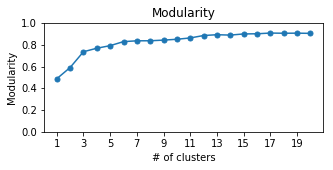

In [48]:
fig = plt.figure(figsize=(5, 2))
plt.title('Modularity')
plt.ylim(0.0, 1.0)
plt.ylabel('Modularity')
plt.xlabel('# of clusters')
plt.xticks(np.arange(1, cntK+1, step = 2))
plot = plt.plot(np.linspace(1,cntK,cntK), metrix_during_iters, marker='o', markersize=5)

#### Partition with suitable scaled median cluster size

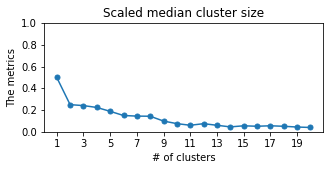

In [51]:
kmeans_partition, L, evals, evecs, metrix_during_iters = Spectral_Clusterization_IO(adj_matrix, cntK, 
                                                               False, scaled_median_cluster_size)
fig = plt.figure(figsize=(5, 2))
plt.title('Scaled median cluster size')
plt.ylim(0.0, 1.0)
plt.ylabel('The metrics')
plt.xlabel('# of clusters')
plt.xticks(np.arange(1, cntK+1, step = 2))
plot = plt.plot(np.linspace(1,cntK,cntK), metrix_during_iters, marker='o', markersize=5)

#### Partition with suitable scaled maximum cluster size

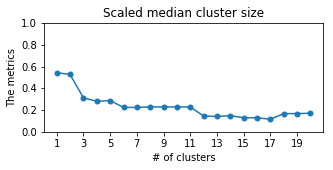

In [53]:
kmeans_partition, L, evals, evecs, metrix_during_iters = Spectral_Clusterization_IO(adj_matrix, cntK, 
                                                               False, scaled_maximum_cluster_size)
fig = plt.figure(figsize=(5, 2))
plt.title('Scaled median cluster size')
plt.ylim(0.0, 1.0)
plt.ylabel('The metrics')
plt.xlabel('# of clusters')
plt.xticks(np.arange(1, cntK+1, step = 2))
plot = plot = plt.plot(np.linspace(1,cntK,cntK), metrix_during_iters, marker='o', markersize=5)

#### Partition with suitable scaled spectrum energy

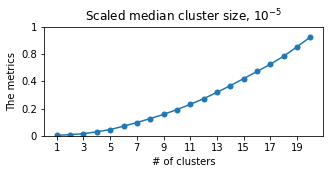

In [68]:
kmeans_partition, L, evals, evecs, metrix_during_iters = Spectral_Clusterization_IO(adj_matrix, cntK, 
                                                               False, scaled_spectrum_energy)
fig = plt.figure(figsize=(5, 2))
plt.title('Scaled median cluster size, $10^{-5}$')
plt.ylim(0.0, 1e-5)
plt.ylabel('The metrics')
plt.xlabel('# of clusters')
plt.xticks(np.arange(1, cntK+1, step = 2))
plt.yticks(np.linspace(0, 1e-5, 5),['0','0.2','0.4','0.8','1'])
plot = plt.plot(np.linspace(1,cntK,cntK), metrix_during_iters, marker='o', markersize=5)

## Normalized Laplacian Matrix
##### the same experiments 

#### Partition with modularity settings

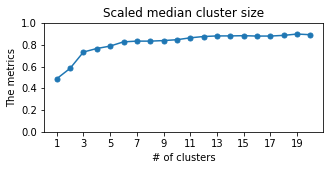

In [55]:
kmeans_partition, L, evals, evecs, metrix_during_iters = Spectral_Clusterization_IO(adj_matrix, cntK, 
                                                                                    True, modularity, kn)
fig = plt.figure(figsize=(5, 2))
plt.title('Scaled median cluster size')
plt.ylim(0.0, 1.0)
plt.ylabel('The metrics')
plt.xlabel('# of clusters')
plt.xticks(np.arange(1, cntK+1, step = 2))
plot = plt.plot(np.linspace(1,cntK,cntK), metrix_during_iters, marker='o', markersize=5)

#### Partition with suitable scaled median cluster size

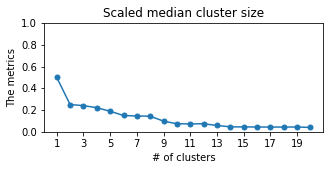

In [56]:
kmeans_partition, L, evals, evecs, metrix_during_iters = Spectral_Clusterization_IO(adj_matrix, cntK, 
                                                               True, scaled_median_cluster_size)
fig = plt.figure(figsize=(5, 2))
plt.title('Scaled median cluster size')
plt.ylim(0.0, 1.0)
plt.ylabel('The metrics')
plt.xlabel('# of clusters')
plt.xticks(np.arange(1, cntK+1, step = 2))
plot = plt.plot(np.linspace(1,cntK,cntK), metrix_during_iters, marker='o', markersize=5)

#### Partition with suitable scaled maximum cluster size

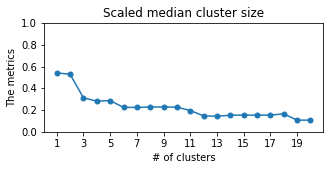

In [57]:
kmeans_partition, L, evals, evecs, metrix_during_iters = Spectral_Clusterization_IO(adj_matrix, cntK, 
                                                               True, scaled_maximum_cluster_size)
fig = plt.figure(figsize=(5, 2))
plt.title('Scaled median cluster size')
plt.ylim(0.0, 1.0)
plt.ylabel('The metrics')
plt.xlabel('# of clusters')
plt.xticks(np.arange(1, cntK+1, step = 2))
plot = plt.plot(np.linspace(1,cntK,cntK), metrix_during_iters, marker='o', markersize=5)

#### Partition with suitable scaled spectrum energy

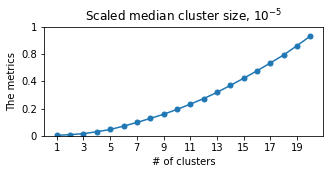

In [69]:
kmeans_partition, L, evals, evecs, metrix_during_iters = Spectral_Clusterization_IO(adj_matrix, cntK, 
                                                               True, scaled_spectrum_energy)
fig = plt.figure(figsize=(5, 2))
plt.title('Scaled median cluster size, $10^{-5}$')
plt.ylim(0.0, 1e-5)
plt.ylabel('The metrics')
plt.xlabel('# of clusters')
plt.xticks(np.arange(1, cntK+1, step = 2))
plt.yticks(np.linspace(0, 1e-5, 5),['0','0.2','0.4','0.8','1'])
plot = plt.plot(np.linspace(1,cntK,cntK), metrix_during_iters, marker='o', markersize=5)